In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Training Data:
X_train: [1.0, 2.0, 3.0, 4.0]
y_train: [2.0, 4.0, 5.0, 8.0]


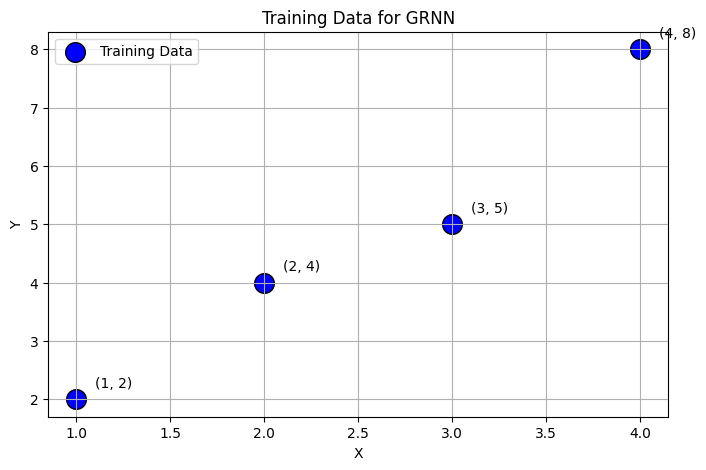

In [2]:
# Training Data: 4 points for regression
# X: input features, y: target values

X_train = torch.tensor([
    [1.0],
    [2.0],
    [3.0],
    [4.0]
], dtype=torch.float32)

y_train = torch.tensor([
    [2.0],   # y = 2*x pattern (approximately)
    [4.0],
    [5.0],
    [8.0]
], dtype=torch.float32)

print("Training Data:")
print("X_train:", X_train.flatten().tolist())
print("y_train:", y_train.flatten().tolist())

# Visualize
plt.figure(figsize=(8, 5))
plt.scatter(X_train.numpy(), y_train.numpy(), s=200, c='blue', edgecolors='black', label='Training Data')
for i in range(len(X_train)):
    plt.annotate(f'({X_train[i].item():.0f}, {y_train[i].item():.0f})', 
                 (X_train[i].item()+0.1, y_train[i].item()+0.2), fontsize=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training Data for GRNN')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
class GRNN:
    """
    Generalized Regression Neural Network implemented from scratch.
    """
    
    def __init__(self, sigma=1.0):
        """
        Initialize GRNN.
        
        Args:
            sigma: Smoothing parameter (bandwidth of Gaussian kernel)
        """
        self.sigma = sigma
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        """
        'Train' the GRNN by storing training data.
        GRNN is a one-pass learning algorithm - no iterative training!
        
        Args:
            X: Training features (n_samples, n_features)
            y: Training targets (n_samples, 1)
        """
        self.X_train = X.clone()
        self.y_train = y.clone()
        print(f"GRNN fitted with {len(X)} training samples.")
        print(f"Sigma (smoothing parameter): {self.sigma}")
        
    def _gaussian_kernel(self, x, xi):
        """
        Compute Gaussian (RBF) kernel between input x and training point xi.
        
        h = exp(-||x - xi||^2 / (2 * sigma^2))
        
        Args:
            x: Input vector
            xi: Training vector
        
        Returns:
            Gaussian kernel value
        """
        distance_sq = torch.sum((x - xi) ** 2)
        return torch.exp(-distance_sq / (2 * self.sigma ** 2))
    
    def predict_single(self, x):
        """
        Predict output for a single input, showing all steps.
        
        Args:
            x: Single input vector
        
        Returns:
            Predicted value
        """
        # Pattern Layer: Compute Gaussian kernel for each training point
        pattern_outputs = []
        for i in range(len(self.X_train)):
            h_i = self._gaussian_kernel(x, self.X_train[i])
            pattern_outputs.append(h_i)
        
        pattern_outputs = torch.stack(pattern_outputs)
        
        # Summation Layer
        # S-summation: sum of all pattern outputs
        S = torch.sum(pattern_outputs)
        
        # D-summation: weighted sum (pattern output * target value)
        D = torch.sum(pattern_outputs * self.y_train.flatten())
        
        # Output Layer: D / S
        y_pred = D / S
        
        return y_pred, pattern_outputs, S, D
    
    def predict(self, X):
        """
        Predict outputs for multiple inputs.
        
        Args:
            X: Input matrix (n_samples, n_features)
        
        Returns:
            Predictions (n_samples, 1)
        """
        predictions = []
        for i in range(len(X)):
            y_pred, _, _, _ = self.predict_single(X[i])
            predictions.append(y_pred)
        
        return torch.stack(predictions).reshape(-1, 1)

print("GRNN class defined!")

GRNN class defined!


In [4]:
# Initialize GRNN with sigma = 0.5
sigma = 0.5
grnn = GRNN(sigma=sigma)

# 'Train' (store training data)
grnn.fit(X_train, y_train)

GRNN fitted with 4 training samples.
Sigma (smoothing parameter): 0.5


In [5]:
# Test input
x_test = torch.tensor([2.5])

print(f"Input: x = {x_test.item()}")
print(f"Sigma: {sigma}")
print("\n" + "="*60)

# Get prediction with details
y_pred, pattern_outputs, S, D = grnn.predict_single(x_test)

print("LAYER 1: Input Layer")
print(f"  Input x = {x_test.item()}")

print("\nLAYER 2: Pattern Layer (Gaussian Kernels)")
print(f"  Formula: h_i = exp(-||x - x_i||^2 / (2σ^2))")
print(f"  σ = {sigma}, 2σ² = {2 * sigma**2}")
print()

for i in range(len(X_train)):
    xi = X_train[i].item()
    yi = y_train[i].item()
    hi = pattern_outputs[i].item()
    dist_sq = (x_test.item() - xi) ** 2
    print(f"  Neuron {i+1}: x_i={xi:.1f}, y_i={yi:.1f}")
    print(f"           ||x - x_i||² = ({x_test.item()} - {xi})² = {dist_sq:.4f}")
    print(f"           h_{i+1} = exp(-{dist_sq:.4f} / {2*sigma**2}) = {hi:.4f}")
    print()

print("LAYER 3: Summation Layer")
print(f"  S-summation (sum of h_i): S = {' + '.join([f'{h.item():.4f}' for h in pattern_outputs])} = {S.item():.4f}")

weighted_terms = [f"{y_train[i].item():.1f}×{pattern_outputs[i].item():.4f}" for i in range(len(y_train))]
print(f"  D-summation (weighted sum): D = {' + '.join(weighted_terms)} = {D.item():.4f}")

print("\nLAYER 4: Output Layer")
print(f"  ŷ = D / S = {D.item():.4f} / {S.item():.4f} = {y_pred.item():.4f}")

print("\n" + "="*60)
print(f"PREDICTION: For x = {x_test.item()}, ŷ = {y_pred.item():.4f}")

Input: x = 2.5
Sigma: 0.5

LAYER 1: Input Layer
  Input x = 2.5

LAYER 2: Pattern Layer (Gaussian Kernels)
  Formula: h_i = exp(-||x - x_i||^2 / (2σ^2))
  σ = 0.5, 2σ² = 0.5

  Neuron 1: x_i=1.0, y_i=2.0
           ||x - x_i||² = (2.5 - 1.0)² = 2.2500
           h_1 = exp(-2.2500 / 0.5) = 0.0111

  Neuron 2: x_i=2.0, y_i=4.0
           ||x - x_i||² = (2.5 - 2.0)² = 0.2500
           h_2 = exp(-0.2500 / 0.5) = 0.6065

  Neuron 3: x_i=3.0, y_i=5.0
           ||x - x_i||² = (2.5 - 3.0)² = 0.2500
           h_3 = exp(-0.2500 / 0.5) = 0.6065

  Neuron 4: x_i=4.0, y_i=8.0
           ||x - x_i||² = (2.5 - 4.0)² = 2.2500
           h_4 = exp(-2.2500 / 0.5) = 0.0111

LAYER 3: Summation Layer
  S-summation (sum of h_i): S = 0.0111 + 0.6065 + 0.6065 + 0.0111 = 1.2353
  D-summation (weighted sum): D = 2.0×0.0111 + 4.0×0.6065 + 5.0×0.6065 + 8.0×0.0111 = 5.5699

LAYER 4: Output Layer
  ŷ = D / S = 5.5699 / 1.2353 = 4.5090

PREDICTION: For x = 2.5, ŷ = 4.5090


In [6]:
# Test on multiple points
X_test = torch.tensor([[1.5], [2.5], [3.5]], dtype=torch.float32)

print("Predictions on Test Points:")
print("="*40)

predictions = grnn.predict(X_test)

for i in range(len(X_test)):
    print(f"x = {X_test[i].item():.1f} → ŷ = {predictions[i].item():.4f}")

Predictions on Test Points:
x = 1.5 → ŷ = 3.0182
x = 2.5 → ŷ = 4.5090
x = 3.5 → ŷ = 6.4773


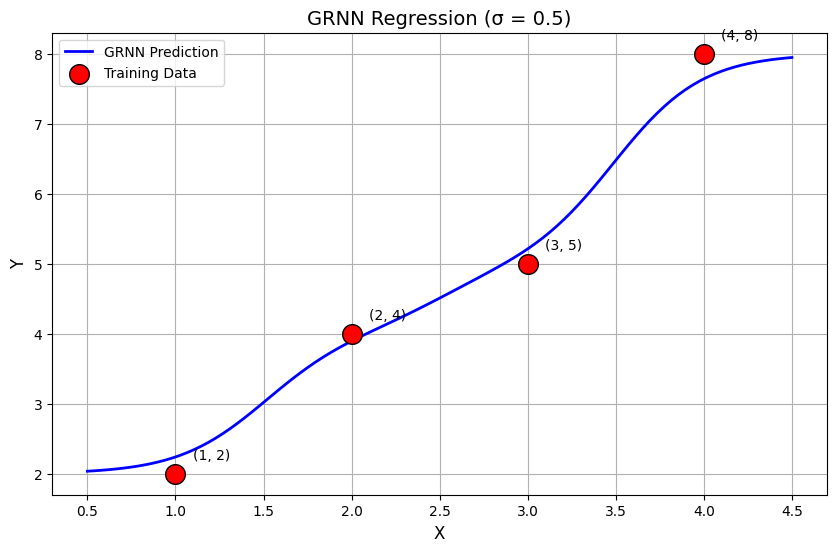

In [7]:
# Generate predictions for smooth curve
X_plot = torch.linspace(0.5, 4.5, 100).reshape(-1, 1)
y_plot = grnn.predict(X_plot)

plt.figure(figsize=(10, 6))

# Plot GRNN prediction curve
plt.plot(X_plot.numpy(), y_plot.numpy(), 'b-', linewidth=2, label='GRNN Prediction')

# Plot training data
plt.scatter(X_train.numpy(), y_train.numpy(), s=200, c='red', 
            edgecolors='black', zorder=5, label='Training Data')

# Add labels to training points
for i in range(len(X_train)):
    plt.annotate(f'({X_train[i].item():.0f}, {y_train[i].item():.0f})', 
                 (X_train[i].item()+0.1, y_train[i].item()+0.2), fontsize=10)

plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title(f'GRNN Regression (σ = {sigma})', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

GRNN fitted with 4 training samples.
Sigma (smoothing parameter): 0.2
GRNN fitted with 4 training samples.
Sigma (smoothing parameter): 0.5
GRNN fitted with 4 training samples.
Sigma (smoothing parameter): 1.0
GRNN fitted with 4 training samples.
Sigma (smoothing parameter): 2.0


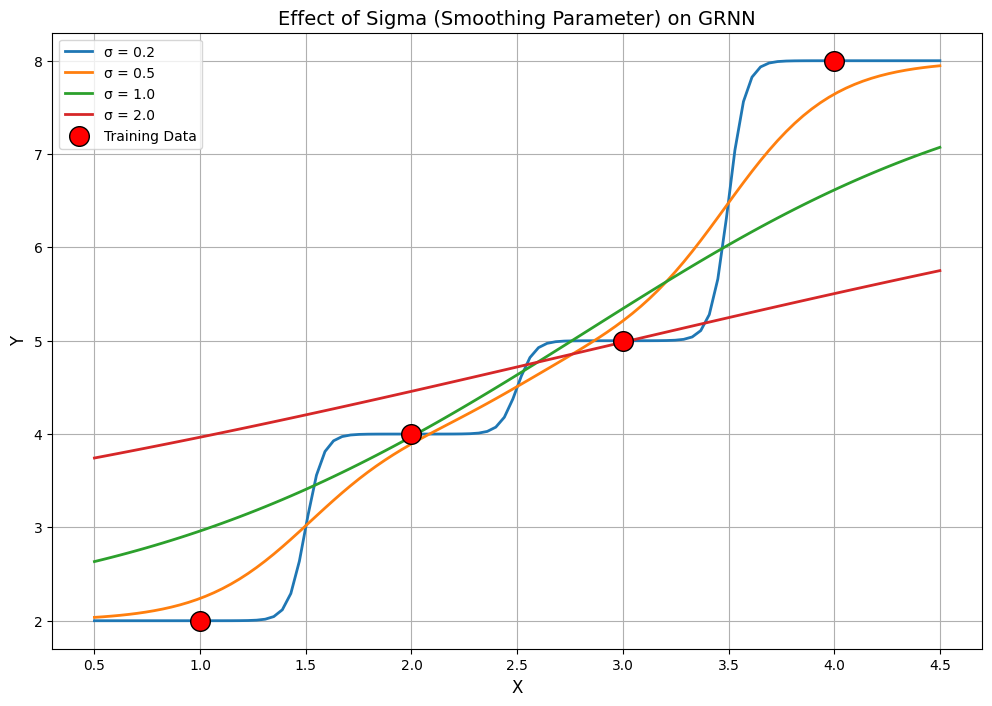

Observations:
- Small σ: More 'peaky', closely follows training points
- Large σ: Smoother curve, more generalization


In [8]:
# Compare different sigma values
sigmas = [0.2, 0.5, 1.0, 2.0]

plt.figure(figsize=(12, 8))

for sigma in sigmas:
    grnn_temp = GRNN(sigma=sigma)
    grnn_temp.fit(X_train, y_train)
    y_plot = grnn_temp.predict(X_plot)
    plt.plot(X_plot.numpy(), y_plot.numpy(), linewidth=2, label=f'σ = {sigma}')

# Plot training data
plt.scatter(X_train.numpy(), y_train.numpy(), s=200, c='red', 
            edgecolors='black', zorder=5, label='Training Data')

plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('Effect of Sigma (Smoothing Parameter) on GRNN', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

print("Observations:")
print("- Small σ: More 'peaky', closely follows training points")
print("- Large σ: Smoother curve, more generalization")

In [9]:
# 2D Input Example
X_train_2d = torch.tensor([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
], dtype=torch.float32)

# Target: XOR-like pattern
y_train_2d = torch.tensor([
    [0.0],
    [1.0],
    [1.0],
    [0.0]
], dtype=torch.float32)

print("2D Training Data:")
for i in range(len(X_train_2d)):
    print(f"  {X_train_2d[i].tolist()} → {y_train_2d[i].item()}")

# Train GRNN
grnn_2d = GRNN(sigma=0.5)
grnn_2d.fit(X_train_2d, y_train_2d)

2D Training Data:
  [0.0, 0.0] → 0.0
  [0.0, 1.0] → 1.0
  [1.0, 0.0] → 1.0
  [1.0, 1.0] → 0.0
GRNN fitted with 4 training samples.
Sigma (smoothing parameter): 0.5


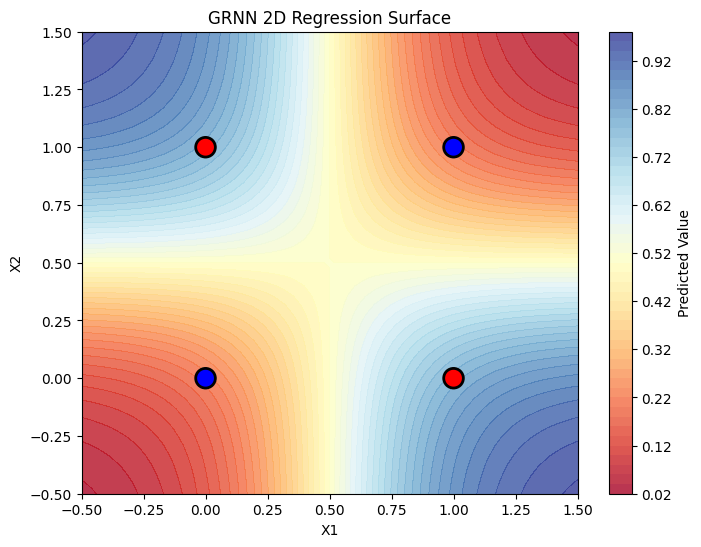

In [10]:
# Visualize 2D GRNN
xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 50), np.linspace(-0.5, 1.5, 50))
grid_input = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
grid_pred = grnn_2d.predict(grid_input).numpy().reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, grid_pred, levels=50, cmap='RdYlBu', alpha=0.8)
plt.colorbar(label='Predicted Value')

# Plot training points
colors = ['blue' if y == 0 else 'red' for y in y_train_2d.flatten()]
plt.scatter(X_train_2d[:, 0].numpy(), X_train_2d[:, 1].numpy(), 
            c=colors, s=200, edgecolors='black', linewidth=2)

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('GRNN 2D Regression Surface')
plt.show()

In [11]:
# Test on training data (should be close to targets)
print("Predictions on Training Data:")
print("="*50)

grnn = GRNN(sigma=0.5)
grnn.fit(X_train, y_train)

train_predictions = grnn.predict(X_train)

print(f"{'X':<10} {'y_true':<10} {'y_pred':<10} {'Error':<10}")
print("-"*40)
for i in range(len(X_train)):
    error = abs(y_train[i].item() - train_predictions[i].item())
    print(f"{X_train[i].item():<10.1f} {y_train[i].item():<10.1f} {train_predictions[i].item():<10.4f} {error:<10.4f}")

mse = torch.mean((y_train - train_predictions) ** 2)
print(f"\nMean Squared Error: {mse.item():.6f}")

Predictions on Training Data:
GRNN fitted with 4 training samples.
Sigma (smoothing parameter): 0.5
X          y_true     y_pred     Error     
----------------------------------------
1.0        2.0        2.2392     0.2392    
2.0        4.0        3.8946     0.1054    
3.0        5.0        5.2122     0.2122    
4.0        8.0        7.6413     0.3587    

Mean Squared Error: 0.060503
